In [3]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from torchvision import transforms
import random
import shutil


In [ ]:
json_dir = "data/sampled_rice_images/json"
output_dir = "data/sampled_rice_masks"
os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(json_dir):
    if not fname.endswith(".json"):
        continue

    path = os.path.join(json_dir, fname)
    with open(path, "r") as f:
        data = json.load(f)

    img_shape = data.get("imageHeight"), data.get("imageWidth")
    mask = Image.new("L", (img_shape[1], img_shape[0]), 0)  # (width, height)
    draw = ImageDraw.Draw(mask)

    for shape in data["shapes"]:
        points = shape["points"]
        polygon = [tuple(p) for p in points]
        draw.polygon(polygon, outline=255, fill=255)

    out_path = os.path.join(output_dir, fname.replace(".json", ".png"))
    mask.save(out_path)

In [4]:
import os
image_dir = "data/rice_images"           # Input images in subfolders
mask_dir = "data/generated_rice_masks"         # Corresponding masks in same subfolder structure
output_dir = "data/masked_rice_images"         # Output masked images
os.makedirs(output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

for root, _, files in os.walk(image_dir):
    for fname in files:
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(root, fname)
        relative_path = os.path.relpath(img_path, image_dir)
        mask_path = os.path.join(mask_dir, relative_path)
        out_path = os.path.join(output_dir, relative_path)

        if not os.path.exists(mask_path):
            print(f"Skipping {relative_path} — no mask found")
            continue

        try:
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            image = transform(Image.open(img_path).convert("RGB"))
            mask = transform(Image.open(mask_path).convert("L"))
            masked = image * mask  # broadcast

            masked_img = transforms.ToPILImage()(masked)
            masked_img.save(out_path)
        except Exception as e:
            print(f"[ERROR] Failed to process {img_path}: {e}")


In [ ]:

def sample_images_per_class(source_dir="data/rice_images", dest_dir="data/sampled_rice_images", num_samples=10):
    os.makedirs(dest_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

        dest_class_path = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_path, exist_ok=True)

        for file_name in sampled_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_class_path, file_name)
            shutil.copy2(src, dst)

        print(f"✅ Sampled {len(sampled_files)} images from {class_name}")

# Run it
sample_images_per_class("data/rice_images", "data/sampled_rice_images", num_samples=10)


✅ Sampled 10 images from blast
✅ Sampled 10 images from brown_spot
✅ Sampled 10 images from hispa
✅ Sampled 10 images from normal


In [5]:
import torch
from torchvision import transforms
from PIL import Image
import os

# === Configuration ===
image_path = "data/train_images/hispa/100085.jpg"  # ← your test image
checkpoint_path = "checkpoints/resnet34_cbam.pt"
class_names = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

# === Image Transform (match your training) ===
transform = transforms.Compose([
                    transforms.Resize(256),  # Resize so shorter side is 256, keeps aspect ratio
                    transforms.CenterCrop(224),  # Crop center to 224x224 (no distortion)
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
                    transforms.RandomRotation(degrees=10),
                    transforms.ToTensor(),
                    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15)),
                ])

# === Load model definition ===
from src.classify_diseases.models.cbam import ResNet34CBAMClassifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34CBAMClassifier(num_classes=len(class_names))
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# === Load and preprocess image ===
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension

# === Make prediction ===
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = outputs.max(1)

print(f"Predicted class: {class_names[predicted.item()]}")


Predicted class: hispa


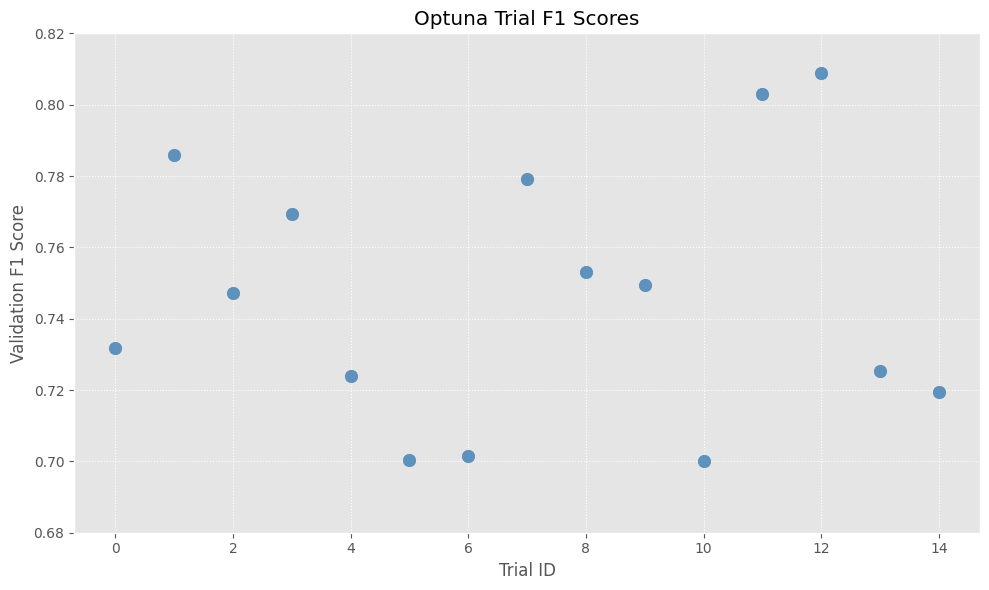

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Generate mock Optuna trial data
np.random.seed(42)

n_trials = 15

trial_ids = np.arange(n_trials)
val_f1_scores = np.random.uniform(0.7, 0.8, n_trials)
val_f1_scores = np.round(val_f1_scores + np.random.normal(0, 0.01, n_trials), 4)
val_f1_scores = np.clip(val_f1_scores, 0.7, 0.91)

# Create a new DataFrame
random_mock_df = pd.DataFrame({
    "trial_id": trial_ids,
    "val_f1_score": val_f1_scores
})


plt.figure(figsize=(10, 6))
plt.scatter(random_mock_df["trial_id"], random_mock_df["val_f1_score"],
            color='steelblue', s=80, alpha=0.85)
plt.title("Optuna Trial F1 Scores")
plt.xlabel("Trial ID")
plt.ylabel("Validation F1 Score")
plt.ylim(0.68, 0.82)
plt.grid(True, linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()
